In [206]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# ITTI algorithm
## build a Gaussian pyramid of the color, brightness, and direction.


In [11]:
def pyramid_image(image):
    level = 9 #pyramid layer
    temp = image.copy()
    i_pyramid = []
    r_pyramid = []
    g_pyramid = []
    b_pyramid = []
    y_pyramid = []
    o_pyramid = [[],[],[],[]]
    filters = []
    for theta in np.arange(0, np.pi, np.pi / 4): 
        kern = cv2.getGaborKernel((11,11), 1.0, theta, np.pi / 2, 0.5, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    for i in range(level):
        dst = cv2.pyrDown(temp) #Gaussian sampling 
        b = dst[:,:,0]
        g = dst[:,:,1]
        r = dst[:,:,2]
        i_pyramid.append((r+b+g)/3)
        r_pyramid.append(r-(g+b)/2)
        g_pyramid.append(g-(r+b)/2)
        b_pyramid.append(b-(g+r)/2)
        y_pyramid.append(r+g-2*(abs(r-g)+b))
        for j in range(4):
            accum = np.zeros_like(dst)
            for kern in filters[j]:
                fimg = cv2.filter2D(dst, cv2.CV_8UC1, kern)
                accum = np.maximum(accum, fimg, accum)
            tmp = np.asarray(accum)
            t = (tmp[:,:,0]+tmp[:,:,1]+tmp[:,:,2])/3
            o_pyramid[j].append(t)
        temp = dst.copy()
    return i_pyramid,r_pyramid,g_pyramid,b_pyramid,y_pyramid,o_pyramid


## calculate the brightness feature map, color feature map, and directional feature map


In [3]:
def feature_map(i_pyramid,r_pyramid,g_pyramid,b_pyramid,y_pyramid,o_pyramid):
    c = [2,3,4]
    delta = [3,4]
    i_map = []
    rg_map = []
    by_map = []
    o_map = [[],[],[],[]]
    for i in range(3):
        for j in range(2):
            cc = c[i]
            s = cc + delta[j]
            x,y = np.shape(i_pyramid[cc])
            image = Image.fromarray(i_pyramid[s])
            image = image.resize((x,y))
            image = np.asarray(image)
            i_map.append(i_pyramid[cc]-image)
            tmp = g_pyramid[s] - r_pyramid[s]
            image = Image.fromarray(tmp)
            image = image.resize((x,y))
            image = np.asarray(image)
            rg_map.append((r_pyramid[cc]-g_pyramid[cc])-image)
            tmp = y_pyramid[s] - b_pyramid[s]
            image = Image.fromarray(tmp)
            image = image.resize((x,y))
            image = np.asarray(image)
            by_map.append((b_pyramid[cc]-y_pyramid[cc])-image)
            for k in range(4):
                image = Image.fromarray(o_pyramid[k][s])
                image = image.resize((x,y))
                image = np.asarray(image)
                o_map[k].append(o_pyramid[k][cc]-image)
    return i_map,rg_map,by_map,o_map

## Obtain saliency map


In [250]:
# Normalized function
def normalized(img):
    M = np.max(img)
    m = []
    x,y = np.shape(img)
    for i in range(4,x,4):
        for j in range(4,y,4):
            tmp = img[i-4:i,j-4:j]
            m.append(np.max(tmp))
    mean_m = np.mean(m)
    img = img * (M-mean_m) * (M-mean_m)
    return img

In [16]:
#Obtain brightness, Color and direction saliency map
def saliency_map(i_map,rg_map,by_map,o_map):
    x,y  = np.shape(i_map[0])
    i_saliency = np.zeros((x,y))
    c_saliency = np.zeros((x,y))
    o_saliency = np.zeros((x,y))
    o_tmp = [[],[],[],[]]
    for i in range(4):
        o_tmp[i].append(np.zeros((x,y)))
    for i in range(6):
        tmp = normalized(i_map[i])
        image = Image.fromarray(tmp)
        image = image.resize((x,y))
        image = np.asarray(image)
        i_saliency += image
        tmp = normalized(rg_map[i])+normalized(by_map[i])
        image = Image.fromarray(tmp)
        image = image.resize((x,y))
        image = np.asarray(image)
        c_saliency += image
        for j in range(4):
            tmp = normalized(o_map[j][i])
            image = Image.fromarray(tmp)
            image = image.resize((x,y))
            image = np.asarray(image)
            o_tmp[j] += image
    for i in range(4):
        a,b,c = o_tmp[i].shape
        x = o_tmp[i].reshape((b,c))
        tmp = normalized(x)
        o_saliency += tmp
    s = (normalized(o_saliency)+normalized(i_saliency)+normalized(c_saliency))/3
    return s

## test

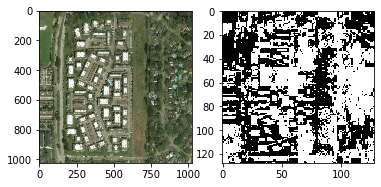

In [157]:
image_orgin = cv2.imread('E:/xview2/train/images/images/hurricane-harvey_00000358_pre_disaster.png')
image_rgb = image_orgin[:,:,::-1]
i_pyramid,r_pyramid,g_pyramid,b_pyramid,y_pyramid,o_pyramid = pyramid_image(image_orgin)
i_map,rg_map,by_map,o_map = feature_map(i_pyramid,r_pyramid,g_pyramid,b_pyramid,y_pyramid,o_pyramid)
s = saliency_map(i_map,rg_map,by_map,o_map)
s = Image.fromarray(s)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(image_rgb)
plt.subplot(1,2,2)
plt.imshow(s)
plt.show()

# Spectral Residual Algorithm

In [108]:
def sr_detection(mat):
    FFT = np.fft.fft2(np.float32(mat))
    LogAmplitude = np.log(np.abs(FFT))
    Phase = np.angle(FFT)
    SpectralResidual = LogAmplitude - cv2.blur(LogAmplitude, (5,5))
    saliencyMap = abs(np.fft.ifft2(np.exp(SpectralResidual+1j*Phase)))**2
    saliencyMap = cv2.GaussianBlur(saliencyMap, (7, 7), 0)
    return saliencyMap

## test

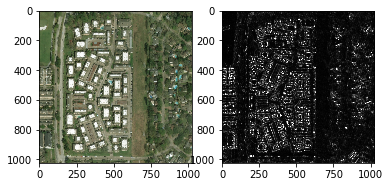

In [141]:
image_orgin = cv2.imread('E:/xview2/train/images/images/hurricane-harvey_00000358_pre_disaster.png')
image_gray = cv2.cvtColor(image_orgin,cv2.COLOR_BGR2GRAY)
image_orgin = image_orgin[:,:,::-1]
t = sr_detection(image_gray)
t = t/np.max(t)*7000
t = Image.fromarray(t)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(image_orgin)
plt.subplot(1,2,2)
plt.imshow(t,cmap='gray')
plt.show()

# Frequency Tuned Algorithm

In [142]:
def ft_detection(img):
    img = cv2.GaussianBlur(img,(5,5), 0)
    gray_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l_mean = np.mean(gray_lab[:,:,0])
    a_mean = np.mean(gray_lab[:,:,1])
    b_mean = np.mean(gray_lab[:,:,2])
    lab = np.square(gray_lab- np.array([l_mean, a_mean, b_mean]))
    lab = np.sum(lab,axis=2)
    lab = lab/np.max(lab)
    return lab

## test

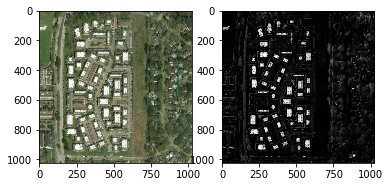

In [144]:
image_orgin = cv2.imread('E:/xview2/train/images/images/hurricane-harvey_00000358_pre_disaster.png')
image_orgin = image_orgin[:,:,::-1]
t = ft_detection(image_orgin)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(image_orgin)
plt.subplot(1,2,2)
plt.imshow(t,cmap='gray')
plt.show()

# Histogram Contrast Algorithm

In [214]:
# Quantize color channel
def Quantize(img3f,ratio=0.95,colorNums=(12,12,12)):
    clrTmp = [colorNums[0]-0.0001, colorNums[1]-0.0001, colorNums[2]-0.0001]
    w = [colorNums[1] * colorNums[2], colorNums[2], 1]
    height,width = img3f.shape[:2]
    img3f_0,img3f_1,img3f_2 = cv2.split(img3f)
    idx_img3f_0 = (img3f_0 * clrTmp[0] ).astype(np.int32)* w[0]
    idx_img3f_1 = (img3f_1 * clrTmp[1] ).astype(np.int32)* w[1]
    idx_img3f_2 = (img3f_2 * clrTmp[2] ).astype(np.int32)* w[2]
    idx1i = idx_img3f_0 + idx_img3f_1 + idx_img3f_2
    bincount_pallet = np.bincount(idx1i.reshape(1,-1)[0])
    sort_pallet = np.sort(bincount_pallet)
    argsort_pallet = np.argsort(bincount_pallet)
    numpy_pallet = np.vstack((sort_pallet, argsort_pallet))
    numpy_pallet = numpy_pallet[:, np.nonzero(sort_pallet)]
    num = np.swapaxes(numpy_pallet, 0, 1)[0]                      
    len_num = maxNum = len(num[0])                                
    maxDropNum = int(np.round(height * width * (1 - ratio)))      
    sum_pallet = np.add.accumulate(num[0])
    arg_sum_pallett = np.argwhere(sum_pallet >= maxDropNum)[0][0] 
    maxNum = maxNum - arg_sum_pallett                             
    num_values = num[1][::-1]                                     
    maxNum = 256 if maxNum > 256 else maxNum
    if maxNum <= 10:
        maxNum = 10 if len(num) > 10 else len(num)
    color3i_init0 = (num_values / w[0]).astype(np.int32)
    color3i_init1 = (num_values % w[0]/w[1]).astype(np.int32)
    color3i_init2 = (num_values % w[1]).astype(np.int32)
    color3i = np.array([color3i_init0,color3i_init1,color3i_init2]).T
    zero2maxNum = color3i[:maxNum]                  
    maxNum2len_Num = color3i[maxNum:]               
    temp_matrix = np.zeros((len_num-maxNum,maxNum),dtype=np.int32)
    for i,single in enumerate(maxNum2len_Num):     
        temp_matrix[i] = np.sum(np.square(single-zero2maxNum),axis=1)
    arg_min = np.argmin(temp_matrix, axis=1)
    replaceable_colors = num_values[arg_min]       
    pallet = dict(zip(num_values[:maxNum], range(maxNum)))
    for num_value,index_dist in zip(num_values[maxNum:],replaceable_colors):
        pallet[num_value] = pallet[index_dist]
    idx1i_reshape = idx1i.copy().reshape(1,-1)[0]
    idx1i_0 = np.zeros(height * width, dtype=np.int32)
    for i, v in enumerate(idx1i_reshape):
        idx1i_0[i] = pallet[v]
    idx1i = idx1i_0.reshape((height,width))
    color3f = np.zeros((1, maxNum, 3), np.float32)
    colorNum = np.zeros((1, maxNum), np.int32)
    np.add.at(color3f[0], idx1i, img3f)
    np.add.at(colorNum[0], idx1i, 1)
    colorNum_reshape = colorNum.reshape(color3f.shape[1],1)
    color3f[0] /= colorNum_reshape
    return color3f.shape[1],idx1i,color3f,colorNum

In [215]:
def HC_detection(img_float,delta=0.25):
    binN, idx1i, binColor3f, colorNums1i = Quantize(img_float)                 
    binColor3f = cv2.cvtColor(binColor3f, cv2.COLOR_BGR2Lab)                   
    weight1f = np.zeros(colorNums1i.shape, np.float32)
    cv2.normalize(colorNums1i.astype(np.float32), weight1f, 1, 0, cv2.NORM_L1) 

    binColor3f_reshape = binColor3f.reshape(-1, 3)[:binN]
    similar_dist = squareform(pdist(binColor3f_reshape))
    similar_dist_sort = np.sort(similar_dist)
    similar_dist_argsort = np.argsort(similar_dist)

    weight1f = np.tile(weight1f, (binN, 1))
    color_weight_dist = np.sum(np.multiply(weight1f, similar_dist), axis=1)    

    colorSal = np.zeros((1, binN), np.float64)
    if colorSal.shape[1] < 2:
        return
    tmpNum = int(np.round(binN * delta))                                       
    n = tmpNum if tmpNum > 2 else 2

    similar_nVal = similar_dist_sort[:, :n]
    totalDist_similar = np.sum(similar_nVal, axis=1)
    every_Dist = np.tile(totalDist_similar[:, np.newaxis], (1, n)) - similar_nVal

    idx = similar_dist_argsort[:, :n]
    val_n = np.take(color_weight_dist,idx)                                    

    valCrnt = np.sum(val_n[:, :n] * every_Dist, axis=1)
    newSal_img = valCrnt / (totalDist_similar * n)
    cv2.normalize(newSal_img, newSal_img, 0, 1, cv2.NORM_MINMAX)             
    salHC_img = np.take(newSal_img,idx1i)
    cv2.GaussianBlur(salHC_img, (3, 3), 0, salHC_img)
    cv2.normalize(salHC_img, salHC_img, 0, 1, cv2.NORM_MINMAX)
    return salHC_img

## test 

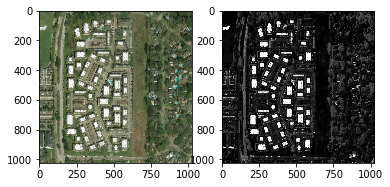

In [216]:
image_orgin = cv2.imread('E:/xview2/train/images/images/hurricane-harvey_00000358_pre_disaster.png')
img3_float = image_orgin.astype(np.float32)
img3_float = img3_float / 255.0
sal = HC_detection(img3_float)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(image_rgb)
plt.subplot(1,2,2)
plt.imshow(sal,cmap='gray')
plt.show()


# Whole Work 

In [240]:
def OTSU(img_gray):
    max_g = 0
    suitable_th = 0
    th_begin = 0
    th_end = 256
    w,h = img_gray.shape
    img_gray = img_gray / np.max(img_gray) * 255
    white = np.ones((w,h))*255
    black = np.zeros((w,h))
    for threshold in range(th_begin, th_end):
        bin_img = img_gray > threshold
        bin_img_inv = img_gray <= threshold
        fore_pix = np.sum(bin_img)
        back_pix = np.sum(bin_img_inv)
        if 0 == fore_pix:
            break
        if 0 == back_pix:
            continue
        w0 = float(fore_pix) / img_gray.size
        u0 = float(np.sum(img_gray * bin_img)) / fore_pix
        w1 = float(back_pix) / img_gray.size
        u1 = float(np.sum(img_gray * bin_img_inv)) / back_pix
        # intra-class variance
        g = w0 * w1 * (u0 - u1) * (u0 - u1)
        if g > max_g:
            max_g = g
            suitable_th = threshold
    ans = np.where(img_gray>suitable_th, white, black)
    return ans


In [241]:
def Gaussian_pyramid(img):
    level = 2 #pyramid layer
    temp = img.copy()
    for i in range(level):
        dst = cv2.pyrDown(temp)
        temp = dst.copy()
    return dst


## test

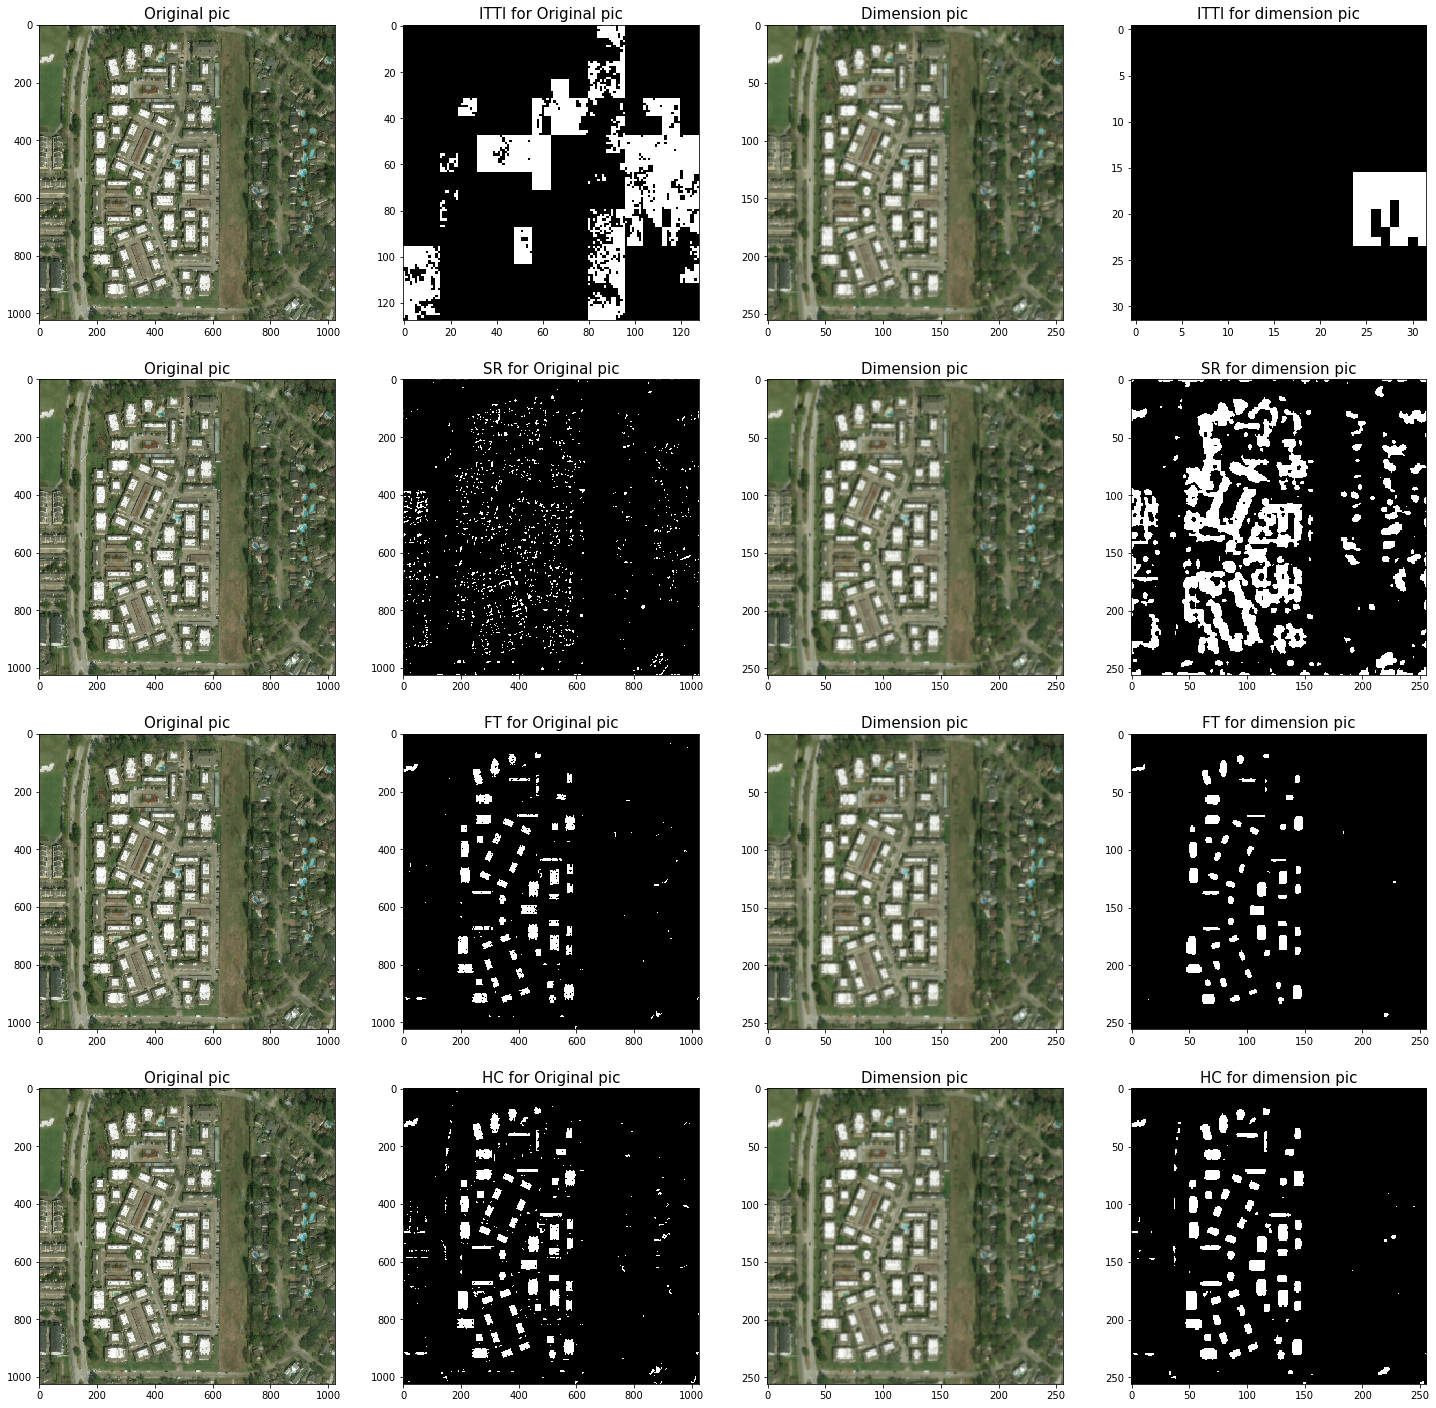

In [261]:
image_orgin = cv2.imread('E:/xview2/train/images/images/hurricane-harvey_00000358_pre_disaster.png')
image_gray = cv2.cvtColor(image_orgin,cv2.COLOR_BGR2GRAY)
img3_float = image_orgin.astype(np.float32)
image_float = img3_float / 255.0
img_rgb = image_orgin[:,:,::-1]

image_d = Gaussian_pyramid(image_orgin)
image_gray_d = cv2.cvtColor(image_d,cv2.COLOR_BGR2GRAY)
img3_float_d = image_d.astype(np.float32)
image_float_d = img3_float_d / 255.0
img_rgb_d = image_d[:,:,::-1]

i_pyramid,r_pyramid,g_pyramid,b_pyramid,y_pyramid,o_pyramid = pyramid_image(image_orgin)
i_map,rg_map,by_map,o_map = feature_map(i_pyramid,r_pyramid,g_pyramid,b_pyramid,y_pyramid,o_pyramid)
itti = saliency_map(i_map,rg_map,by_map,o_map)
sr = sr_detection(image_gray)
ft = ft_detection(image_orgin)
hc = HC_detection(image_float)

itti_result = OTSU(itti)
sr_result = OTSU(sr)
ft_result = OTSU(ft)
hc_result = OTSU(hc)

i_pyramid,r_pyramid,g_pyramid,b_pyramid,y_pyramid,o_pyramid = pyramid_image(image_d)
i_map,rg_map,by_map,o_map = feature_map(i_pyramid,r_pyramid,g_pyramid,b_pyramid,y_pyramid,o_pyramid)
itti_d = saliency_map(i_map,rg_map,by_map,o_map)
sr_d = sr_detection(image_gray_d)
ft_d = ft_detection(image_d)
hc_d = HC_detection(image_float_d)
itti_result_d = OTSU(itti_d)
sr_result_d = OTSU(sr_d)
ft_result_d = OTSU(ft_d)
hc_result_d = OTSU(hc_d)

figure, ax = plt.subplots(4,4, figsize=(25,25))
ax[0][0].set_title("Original pic", fontsize=15), ax[0][0].imshow(img_rgb)
ax[0][1].set_title("ITTI for Original pic", fontsize=15), ax[0][1].imshow(itti_result,cmap='gray')
ax[0][2].set_title("Dimension pic", fontsize=15), ax[0][2].imshow(img_rgb_d)
ax[0][3].set_title("ITTI for dimension pic", fontsize=15), ax[0][3].imshow(itti_result_d,cmap='gray')
ax[1][0].set_title("Original pic", fontsize=15), ax[1][0].imshow(img_rgb)
ax[1][1].set_title("SR for Original pic", fontsize=15), ax[1][1].imshow(sr_result,cmap='gray')
ax[1][2].set_title("Dimension pic", fontsize=15), ax[1][2].imshow(img_rgb_d)
ax[1][3].set_title("SR for dimension pic", fontsize=15), ax[1][3].imshow(sr_result_d,cmap='gray')
ax[2][0].set_title("Original pic", fontsize=15), ax[2][0].imshow(img_rgb)
ax[2][1].set_title("FT for Original pic", fontsize=15), ax[2][1].imshow(ft_result,cmap='gray')
ax[2][2].set_title("Dimension pic", fontsize=15), ax[2][2].imshow(img_rgb_d)
ax[2][3].set_title("FT for dimension pic", fontsize=15), ax[2][3].imshow(ft_result_d,cmap='gray')
ax[3][0].set_title("Original pic", fontsize=15), ax[3][0].imshow(img_rgb)
ax[3][1].set_title("HC for Original pic", fontsize=15), ax[3][1].imshow(hc_result,cmap='gray')
ax[3][2].set_title("Dimension pic", fontsize=15), ax[3][2].imshow(img_rgb_d)
ax[3][3].set_title("HC for dimension pic", fontsize=15), ax[3][3].imshow(hc_result_d,cmap='gray')

plt.show()
